In [3]:
# Import Pytorch
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, Normalize, RandomCrop
from torch.nn import functional as F

# Plotting utils
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

# Get rid of annoying warnings
warnings.filterwarnings("ignore")


# Resnet in Pytorch

This is an attempt to impliment the exact resnet as described in the paper "Deep Residual Learning for Image Recognition" by He et al. (2015). The goal is to do so in a concise "Pytorch" way and test on CIFAR-10 data. (Or maybe Imagenet and Fashion MNIST as well)



## The Data

In [13]:
# Transform data like paper (page 7):
# Horizontal Flip follow by a random crop with a padding of 4, mean subtracted
def make_transforms(mean=0.4246, std=1.0):
    tt = [RandomHorizontalFlip(), RandomCrop(32, padding=4),
          ToTensor(), Normalize(mean=mean, std=std)]
    vt = [ToTensor(), Normalize(mean=mean, std=std)]
    train_transforms = Compose(tt)
    valid_transforms = Compose(vt)

    return train_transforms, valid_transforms

# The CIFAR-10 dataset, see "CIFAR-10 and Analysis" on page 7


class CIFAR10:
    def __init__(self, batch_size=64, mean=0.4246, std=1.0) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(mean, std)
        self.train = datasets.CIFAR10(
            root='data', train=True, transform=train_transforms)
        self.val = datasets.CIFAR10(
            root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = DataLoader(
            self.train, batch_size=batch_size, shuffle=True)
        self.val_dl = DataLoader(self.val, batch_size=batch_size, shuffle=True)


### Subtract mean

In [14]:
# Get mean from data
data = CIFAR10(batch_size=4096*4*2*2, mean=0.0)

for x, y in data.train_dl:
    train_mean = x.mean()

for x, y in data.val_dl:
    val_mean = x.mean()


cifar_mean = (len(data.train)*train_mean + len(data.val)
              * val_mean)/(len(data.train) + len(data.val))

print(f'CIFAR-10 data has total mean across train + val of: {cifar_mean:.4f}')

data = CIFAR10(batch_size=4096*4*2*2, mean=cifar_mean)

for x, y in data.train_dl:
    train_mean = x.mean()

for x, y in data.val_dl:
    val_mean = x.mean()

print(
    f'After subtracting the mean for training is {train_mean:.4f} and validation is {val_mean:.4f}')


CIFAR-10 data has total mean across train + val of: 0.4192
After subtracting the mean for training is -0.0116 and validation is 0.0574


### Visualize Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

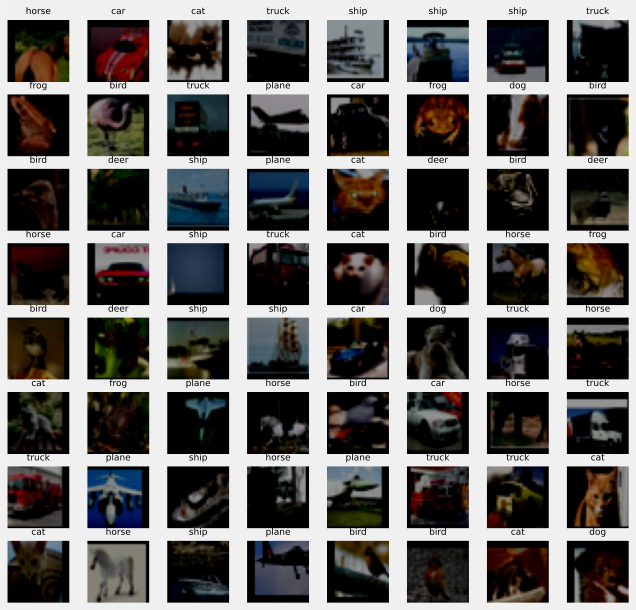

In [15]:
# Check out dataset
def plot_data_check(data, labels, title):
    plt.figure(figsize=(10, 10))
    x, y = next(iter(data.train_dl))

    for i in range(64):

        plt.subplot(8, 8, i+1)
        img = x.permute(0, 2, 3, 1)
        plt.imshow(img[i])
        plt.title(labels[y[i].item()], fontsize=9)
        plt.axis('off')


# CIFAR-10 Data
data = CIFAR10(batch_size=64, mean=cifar_mean)

labels = ['plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")


## The ResNet Network

In [31]:
# All of the "main resnet" models start with a 7x7 kernel with
# 64 output channels and a stride of 2 followed by a 3x3 max pool 
# stride 2.  See table 1 page 5.
class InitConvLayer7(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv7 = nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3)
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

    def forward(self, x):
        return self.max_pool(self.conv7(x))
        

In [33]:
x, y = next(iter(data.train_dl))

model = InitConvLayer7()
print (x.shape)
print (model(x).shape)

torch.Size([64, 3, 32, 32])
torch.Size([64, 64, 8, 8])
